### process data for general Task1

In [6]:
"""
Build a 'Logistics delay' table for component K7 (full outer join version).

- Reads the two input CSVs with automatic delimiter detection.
- Keeps all rows from both datasets, even if IDNummer does not match.
- Assumes goods are issued one day after the production date (if available).
- Computes logistics delay only where both production and receiving dates exist.
- Saves to case/data/Logistics_delay.csv
"""

import os
import pandas as pd

SRC_COMPONENTS = "source/Logistikverzug/Komponente_K7.csv"
SRC_LOGISTICS  = "source/Logistikverzug/Logistikverzug_K7.csv"
OUT_PATH       = "case/data/Logistics_delay.csv"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)

def read_csv_smart(path: str) -> pd.DataFrame:
    """Read CSV with auto delimiter detection and basic cleanup."""
    df = pd.read_csv(path, sep=None, engine="python", dtype=str)
    # drop unnamed index-like columns
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
    # tidy headers
    df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
    # strip spaces/quotes only for string columns (no applymap deprecation)
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.strip().str.strip('"')
    return df

# ---- Load sources
components_df = read_csv_smart(SRC_COMPONENTS)
logistics_df  = read_csv_smart(SRC_LOGISTICS)

# ---- Normalize expected German headers (keep original naming)
rename_map = {
    "IDNummer": "IDNummer",
    "Produktionsdatum": "Produktionsdatum",
    "Wareneingang": "Wareneingang",
    "Herstellernummer": "Herstellernummer",
    "Werksnummer": "Werksnummer",
    "Fehlerhaft": "Fehlerhaft",
}
components_df = components_df.rename(columns={c: rename_map.get(c, c) for c in components_df.columns})
logistics_df  = logistics_df.rename(columns={c: rename_map.get(c, c) for c in logistics_df.columns})

# ---- Parse dates where present
def to_date(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

for df in (components_df, logistics_df):
    if "Produktionsdatum" in df.columns:
        df["Produktionsdatum"] = to_date(df["Produktionsdatum"])
    if "Wareneingang" in df.columns:
        df["Wareneingang"] = to_date(df["Wareneingang"])

# ---- Full outer join so that all IDs from both files are kept
merged_df = pd.merge(
    components_df.add_prefix("comp_"),
    logistics_df.add_prefix("logi_"),
    left_on="comp_IDNummer",
    right_on="logi_IDNummer",
    how="outer"
)

# ---- Helpers to safely coalesce columns (even if one side is missing)
def safe_series(df: pd.DataFrame, name: str, dtype="object"):
    """Return df[name] if present else an empty-like Series aligned to df with NA/NaT."""
    if name in df.columns:
        return df[name]
    if dtype == "datetime64[ns]":
        return pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
    return pd.Series(pd.NA, index=df.index, dtype="object")

def coalesce_cols(df: pd.DataFrame, left: str, right: str, dtype="object") -> pd.Series:
    a = safe_series(df, left, dtype=dtype)
    b = safe_series(df, right, dtype=dtype)
    return a.where(a.notna(), b)

# ---- Coalesce core fields
id_series          = coalesce_cols(merged_df, "comp_IDNummer", "logi_IDNummer", dtype="object")
manufacturer_no    = coalesce_cols(merged_df, "comp_Herstellernummer", "logi_Herstellernummer", dtype="object")
plant_no           = coalesce_cols(merged_df, "comp_Werksnummer", "logi_Werksnummer", dtype="object")
production_date    = coalesce_cols(merged_df, "comp_Produktionsdatum", "logi_Produktionsdatum", dtype="datetime64[ns]")
receiving_date     = coalesce_cols(merged_df, "comp_Wareneingang", "logi_Wareneingang", dtype="datetime64[ns]")

# Fehlerhaft can appear in either file; keep whichever is non-null, cast to nullable integer where possible
defect_flag_raw = coalesce_cols(merged_df, "comp_Fehlerhaft", "logi_Fehlerhaft", dtype="object")
defect_flag = pd.to_numeric(defect_flag_raw, errors="coerce").astype("Int64")

# ---- Compute derived fields
issue_date = production_date + pd.to_timedelta(1, unit="D")  # goods issued 1 day after production
logistics_delay_days = (receiving_date - issue_date).dt.days  # may be NaN if either date missing

# component_number: extract the last group of digits from IDNummer (e.g., K7-114-1142-3 -> 3)
component_number = (
    id_series.astype("string")
    .str.extract(r"(\d+)(?!.*\d)")[0]
    .astype("Int64")
)

# ---- Build final table
final_df = pd.DataFrame({
    "IDNummer": id_series,
    "component_number": component_number,         # new column (last numeric token of ID)
    "Herstellernummer": manufacturer_no,
    "Werksnummer": plant_no,
    "Produktionsdatum": production_date,
    "IssueDate": issue_date,
    "Wareneingang": receiving_date,
    "LogisticsDelay_days": logistics_delay_days,
    "Fehlerhaft": defect_flag                     # keep defect flag
})

# Keep all rows, sort for readability
final_df = final_df.sort_values(by=["IDNummer", "Produktionsdatum", "Wareneingang"]).reset_index(drop=True)

# ---- Save
final_df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"Saved logistics delay table with {len(final_df)} rows to: {OUT_PATH}")



Saved logistics delay table with 306490 rows to: case/data/Logistics_delay.csv


## a

/opt/anaconda3/envs/es/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


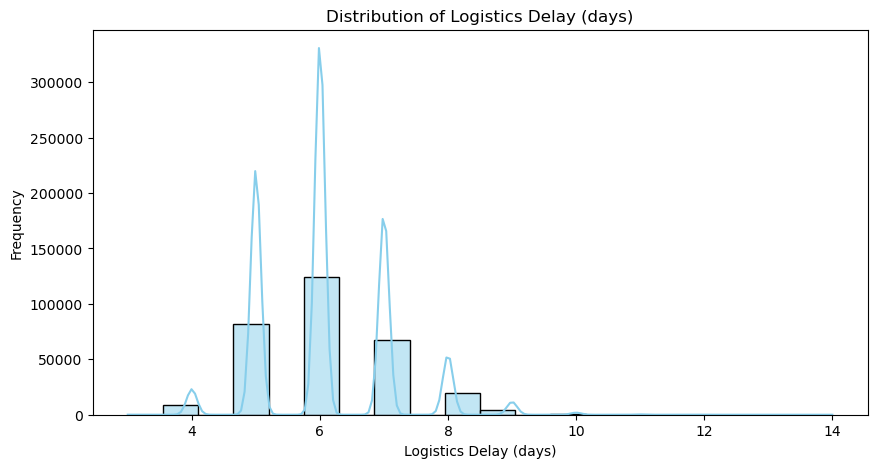

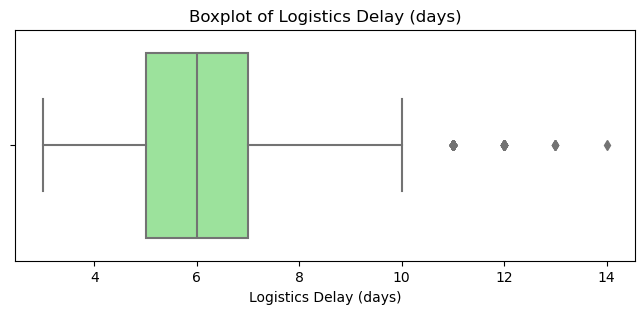

Shapiro-Wilk Test: statistic=0.9021, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.2308, p-value=0.0000
Skewness: 0.5674, Kurtosis: 0.6300
Anderson-Darling Test statistic: 13719.970984800428
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


/opt/anaconda3/envs/es/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================
# 1. Load the dataset
# ==========================
# File path to the dataset
file_path = "case/data/Logistics_delay.csv"

# Read CSV into DataFrame
df_components = pd.read_csv(file_path)

# ==========================
# 2. Extract the relevant column
# ==========================
# We focus on the logistics delay column
logistics_delay_days = df_components["LogisticsDelay_days"].dropna()

# ==========================
# 3. Visualize the distribution
# ==========================
plt.figure(figsize=(10, 5))

# Histogram with KDE
sns.histplot(logistics_delay_days, kde=True, bins=20, color="skyblue")
plt.title("Distribution of Logistics Delay (days)")
plt.xlabel("Logistics Delay (days)")
plt.ylabel("Frequency")
plt.show()

# Boxplot to detect skewness and outliers
plt.figure(figsize=(8, 3))
sns.boxplot(x=logistics_delay_days, color="lightgreen")
plt.title("Boxplot of Logistics Delay (days)")
plt.xlabel("Logistics Delay (days)")
plt.show()

# ==========================
# 4. Statistical tests for distribution shape
# ==========================

# ---- 4.1 Shapiro-Wilk Test for normality ----
# Null hypothesis (H0): data is drawn from a normal distribution
shapiro_stat, shapiro_p = stats.shapiro(logistics_delay_days)
print(f"Shapiro-Wilk Test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# ---- 4.2 Kolmogorov–Smirnov Test against normal distribution ----
# First, normalize the data
mean_delay = np.mean(logistics_delay_days)
std_delay = np.std(logistics_delay_days, ddof=1)
ks_stat, ks_p = stats.kstest(
    (logistics_delay_days - mean_delay) / std_delay,
    "norm"
)
print(f"Kolmogorov-Smirnov Test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

# ---- 4.3 Skewness and Kurtosis ----
# Skewness: positive means right-skewed, negative means left-skewed
skewness_value = stats.skew(logistics_delay_days)
# Kurtosis: >0 is leptokurtic (heavy-tailed), <0 is platykurtic (light-tailed)
kurtosis_value = stats.kurtosis(logistics_delay_days)
print(f"Skewness: {skewness_value:.4f}, Kurtosis: {kurtosis_value:.4f}")

# ==========================
# 5. Non-parametric alternative
# ==========================
# If data is not normal, we might consider fitting another distribution (e.g., exponential, Poisson)
# Example: Anderson-Darling test for normality
anderson_result = stats.anderson(logistics_delay_days, dist="norm")
print("Anderson-Darling Test statistic:", anderson_result.statistic)
print("Critical values:", anderson_result.critical_values)
print("Significance levels:", anderson_result.significance_level)

# ==========================
# 6. Approach summary (to be written in report)
# ==========================
# 1. Visualized the data with histogram + KDE and boxplot.
# 2. Tested normality using Shapiro-Wilk, Kolmogorov–Smirnov, and Anderson-Darling tests.
# 3. Computed skewness and kurtosis to understand shape.
# 4. If tests reject normality (p-value < 0.05), consider fitting other distributions (e.g., lognormal, gamma).


## b

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

# ==========================
# 1. Load the dataset
# ==========================
# File path to the dataset (change to your actual file path)
file_path = "case/data/Logistics_delay.csv"

# Read the CSV (assuming it's actually comma-separated despite the .vsv extension)
df_logistics = pd.read_csv(file_path)

# ==========================
# 2. Convert dates to datetime objects
# ==========================
df_logistics["IssueDate"] = pd.to_datetime(df_logistics["IssueDate"])
df_logistics["Wareneingang"] = pd.to_datetime(df_logistics["Wareneingang"])

# ==========================
# 3. Recalculate logistics delay considering weekends
# ==========================
# Approach:
# - Loop through each row
# - Count only business days between IssueDate and Wareneingang
# - Exclude weekends (Saturday=5, Sunday=6)

logistics_delay_business_days = []

for issue_date, arrival_date in zip(df_logistics["IssueDate"], df_logistics["Wareneingang"]):
    # Create a date range from issue date (next day after production) to arrival date
    date_range = pd.date_range(start=issue_date, end=arrival_date, freq="D")
    
    # Count days excluding weekends
    business_days = sum(1 for day in date_range if day.weekday() < 5) - 1  # exclude IssueDate day itself
    logistics_delay_business_days.append(business_days)

# Add new column to DataFrame
df_logistics["LogisticsDelay_business_days"] = logistics_delay_business_days

# ==========================
# 4. Calculate mean logistics delay (business days)
# ==========================
mean_logistics_delay_business = np.mean(df_logistics["LogisticsDelay_business_days"])
print(f"Mean logistics delay (business days): {mean_logistics_delay_business:.2f} days")

# ==========================
# 5. Interpretation (to be written in the report)
# ==========================
# Interpretation idea:
# - This mean value represents the *average waiting time* for goods to arrive after shipment,
#   excluding weekend days where logistics are assumed not to operate.
# - If the mean is significantly lower than the raw calendar-day delay, it suggests weekends 
#   are a major factor in perceived delays.
# - If still high, could indicate operational inefficiencies, customs delays, or route distance.

# ==========================
# 6. Possible alternative measures:
# ==========================
# - Median delay (business days) to avoid skew from extreme values
median_logistics_delay_business = np.median(df_logistics["LogisticsDelay_business_days"])
print(f"Median logistics delay (business days): {median_logistics_delay_business:.2f} days")

# - 90th percentile to understand worst-case delays
p90_logistics_delay_business = np.percentile(df_logistics["LogisticsDelay_business_days"], 90)
print(f"90th percentile logistics delay (business days): {p90_logistics_delay_business:.2f} days")

# - Calendar days mean delay for comparison
mean_logistics_delay_calendar = np.mean(df_logistics["LogisticsDelay_days"])
print(f"Mean logistics delay (calendar days): {mean_logistics_delay_calendar:.2f} days")

# ==========================
# Summary for the report:
# ==========================
# 1. Calculated mean logistics delay excluding weekends to get a business-days perspective.
# 2. Compared with calendar-day delays to assess the impact of weekends.
# 3. Suggested using median and percentile measures for a more robust picture of delays.


FileNotFoundError: [Errno 2] No such file or directory: 'case/data/Logistics_delay.vsv'